In [1]:
import pandas as pd
from sklearn import preprocessing
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from modules.gnnad.graphanomaly_cleaned import GNNAD
from modules.preprocessing_modules.data_preprocessing import Data_Formatter, Data_Preprocessor

## Load data

In [2]:
try:
    df_loaded
except NameError: # read in training data
    # read in test data
    df_loaded = pd.read_csv("production_datasets/DASIV04.csv")
    df_loaded = Data_Formatter(df_loaded).df
    
df = df_loaded.copy()

C:\Users\AZIZON\AppData\Local\Temp\ipykernel_8280\445618628.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loaded = pd.read_csv("production_datasets/DASIV04.csv")


In [3]:
params = {}
model_params = {}

model_params['epoch'] = 1
model_params['topk'] = 11                        # 11 seems to work the best. number of top-k neighbors to consider for each node when creating the learned graph structure
model_params['errors_topk'] = 11                  # 7 seems to work the best. Number of top-k errors to consider for detecting anomalies
model_params['slide_win'] = 15                   # Window size. 15 seems to work well
model_params['slide_stride'] = 1                 # Stride size. 2 seems to work well
model_params['device'] = "cuda"
model_params['shuffle_train'] = False             # Shuffles the training set after validation set was created, False seems to work much better
model_params['smoothen_error'] = False            # Smoothen the error scores. Using False will increase the precision and reduce the number of false positives
model_params['validation_size'] = 300
model_params['batch'] = 100                      # 256 seems to work well
model_params['early_stop_win'] = 20
model_params['loss_func'] = "mse"                # "mse" or "mae". MSE seems to work better overall.
model_params['use_deterministic'] = True
model_params['input_column_names'] = df.columns[:-1].tolist()           # Names of the input columns except the 'Fault' column

In [4]:
import warnings

# Ignore specific user warnings about non-deterministic operations
warnings.filterwarnings("ignore", message="scatter_reduce_cuda does not have a deterministic implementation")

In [5]:
scaler = preprocessing.RobustScaler()

test_size = 432 # 432 is 3 days of data
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.index = df["timestamp"]

test_start = pd.to_datetime("2024-06-01 00")

test_end = test_start + pd.Timedelta(days=1)
train, test = df[:test_start], df[test_start:test_end] 

train_processed = Data_Preprocessor(train, scaler=scaler, train_data=True).df
test_processed = Data_Preprocessor(test, scaler=scaler).df

test_prev_day_start = test_start - pd.Timedelta(days=1)
test_prev_day_end = test_start
test_prev_day = df[test_prev_day_start:test_prev_day_end]

In [6]:
df = df_loaded.copy()
# Store results

# Number of splits (folds)
window_size=model_params['slide_win']
n_steps = len(test_processed) - window_size - 1

# Initialize the model
model = GNNAD(**model_params)
model.fit(train_processed)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Iterate over the metrics in the JSON data
def sum_drift_scores(report):
    total_drift_score = 0
    for metric in report['metrics']:
        if metric['metric'] == 'DataDriftTable':
            # Extract the drift scores from the 'drift_by_columns' dictionary
            drift_by_columns = metric['result']['drift_by_columns']
            for column_data in drift_by_columns.values():
                drift_score = column_data['drift_score']
                total_drift_score += drift_score
                
    return total_drift_score

In [ ]:
model.threshold

3.001301119139416

In [ ]:
error_sums = []
drift_scores = []
predictions = []

for step in range(n_steps):
    test_start = step
    test_end = step + window_size + 4
    test_set = test_processed.iloc[test_start:test_end]
    
    pred_labels = model.predict(test_set)
    error_sum = model.test_avg_loss
    error_sums.append(error_sum)
    predictions.append(pred_labels)
    print(pred_labels)
    if len(pred_labels) == 0:
        print("The list is empty")

    report = Report(metrics=[DataDriftPreset()])
    report.run(reference_data=train_processed[:-144], current_data=test_set)
    # Save the report as an HTML file

    # Get the dataset drift score
    drift_score = sum_drift_scores(report.as_dict())
    drift_scores.append(drift_score)

[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0]
[0 0]


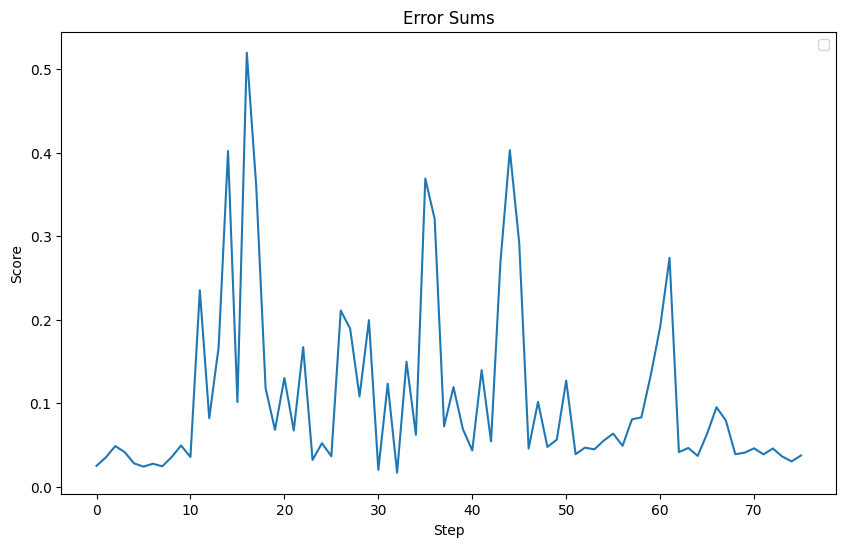

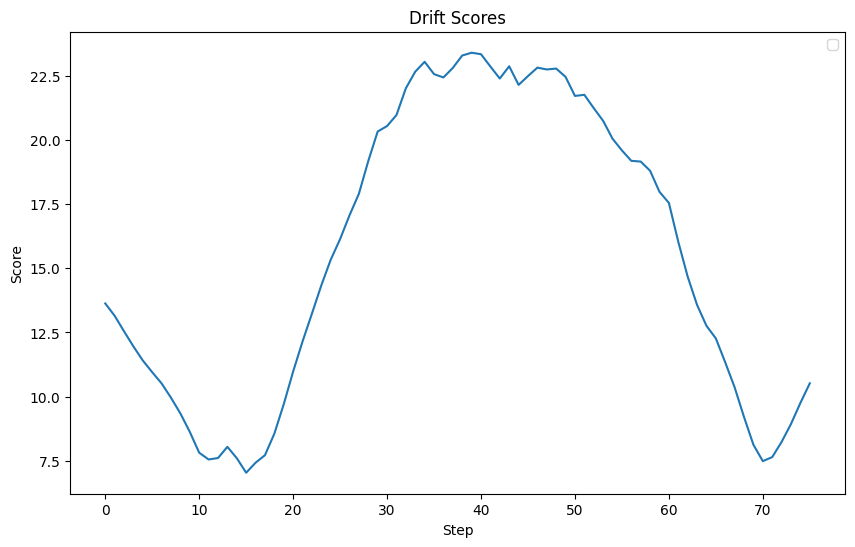

In [ ]:
import matplotlib.pyplot as plt

# Visualize error_sums and drift_scores
plt.figure(figsize=(10, 6))
plt.plot(error_sums)
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Error Sums')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(drift_scores)
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Drift Scores')
plt.legend()
plt.show()
